In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
# figure size in inches
rcParams['figure.figsize'] = 8, 4

sns.set(font_scale=1.5)

import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
path = '../data/all-data/'
df = pd.read_csv(f'{path}intrusion_detection_data_v1.csv')
df.shape

(928344, 70)

In [5]:
# Create train, test split
train, test = train_test_split(df, train_size=0.7, random_state=123, stratify=df.label.values)
print(f'Train size: {train.shape[0]}')
print(f'Test size: {test.shape[0]}')

Train size: 649840
Test size: 278504


In [6]:
# Split train and test into features and target.
X_train = train.iloc[:, :-2]
y_train = train['label']

X_test = test.iloc[:, :-2]
y_test = test['label']

In [7]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
x_test_std = scaler.fit_transform(X_test)

ohe = OneHotEncoder()
ohe.fit(y_train.values.reshape(-1, 1))
y_train_ohe = ohe.transform(y_train.values.reshape(-1, 1)).toarray()
y_test_ohe = ohe.transform(y_test.values.reshape(-1, 1)).toarray()

#### Logistic Regression

In [11]:
# Define Logistic Regression model.
lr_model = LogisticRegression(solver='sag', dual=False, max_iter=1000)

# Train the model.
lr_model = lr_model.fit(X_train_std, y_train)

# Test the model.
y_pred = lr_model.predict(x_test_std)
print(classification_report(y_test, y_pred))

c:\Python38\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


              precision    recall  f1-score   support

      benign       0.97      0.96      0.97    150796
         bot       1.00      0.02      0.04       584
 brute_force       0.91      0.45      0.60      2745
        ddos       0.87      1.00      0.93     38404
         dos       0.96      0.92      0.94     58124
    portscan       0.97      0.99      0.98     27208
  web_attack       0.71      0.03      0.07       643

    accuracy                           0.95    278504
   macro avg       0.91      0.63      0.65    278504
weighted avg       0.95      0.95      0.95    278504



#### Linear SVC

In [8]:
# Define Linear SVC model object.
l_svm_model = LinearSVC(dual=False)

# Train the model.
l_svm_model.fit(X_train_std, y_train)

# Test the model.
y_pred = l_svm_model.predict(x_test_std)
print(classification_report(y_test, y_pred))

c:\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

      benign       0.98      0.99      0.98    150796
         bot       0.25      0.02      0.04       584
 brute_force       0.95      0.96      0.96      2745
        ddos       0.97      1.00      0.98     38404
         dos       0.99      0.97      0.98     58124
    portscan       0.98      1.00      0.99     27208
  web_attack       0.17      0.04      0.07       643

    accuracy                           0.98    278504
   macro avg       0.76      0.71      0.71    278504
weighted avg       0.98      0.98      0.98    278504



#### KNN

In [6]:
# Define KNN model object.
knn_model = KNeighborsClassifier(n_neighbors=50)

# Train the model.
knn_model.fit(X_train_std, y_train_ohe)

# Test the model.
y_pred = knn_model.predict(x_test_std)
print(classification_report(y_test_ohe, y_pred, target_names=ohe.categories_[0]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    150796
           1       0.95      0.70      0.81       584
           2       0.99      0.97      0.98      2745
           3       1.00      0.99      0.99     38404
           4       0.99      1.00      0.99     58124
           5       1.00      1.00      1.00     27208
           6       0.94      0.89      0.91       643

   micro avg       0.99      0.99      0.99    278504
   macro avg       0.98      0.94      0.95    278504
weighted avg       0.99      0.99      0.99    278504
 samples avg       0.99      0.99      0.99    278504



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Save KNN trained model.
file_name = '../assets/model/knn_model.sav'
joblib.dump(knn_model, file_name)

['../assets/model/knn_model.sav']

In [12]:
# Load KNN trained model.
loaded_model = joblib.load(file_name)
y_pred = loaded_model.predict(x_test_std)
print(classification_report(y_test_ohe, y_pred, target_names=ohe.categories_[0]))

              precision    recall  f1-score   support

      benign       0.99      1.00      0.99    150796
         bot       0.95      0.70      0.81       584
 brute_force       0.99      0.97      0.98      2745
        ddos       1.00      0.99      0.99     38404
         dos       0.99      1.00      0.99     58124
    portscan       1.00      1.00      1.00     27208
  web_attack       0.94      0.89      0.91       643

   micro avg       0.99      0.99      0.99    278504
   macro avg       0.98      0.94      0.95    278504
weighted avg       0.99      0.99      0.99    278504
 samples avg       0.99      0.99      0.99    278504



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Define KNN model object.
knn_model = KNeighborsClassifier()

# Define scoring metrics.
score = ['precision', 'recall', 'f1', 'accuracy']

# Define 10 fold CV object.
kfold = KFold(n_splits=5)

# Define grid of hyperparameter values.
hyper_grid = {'n_neighbors': range(2, 65, 15)}

# Tune the model pipline using grid search
knn_grid_search = GridSearchCV(knn_model, hyper_grid, cv=kfold)
knn_grid_search_trained = knn_grid_search.fit(X_train_std, y_train_ohe)

#### Decision Tree

In [21]:
# Define Decision Tree model object.
dt_model = DecisionTreeClassifier()

# Train the model.
dt_model.fit(X_train_std, y_train)

# Test the model
y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.96      0.32      0.48    100530
         bot       0.00      0.00      0.00       390
 brute_force       0.00      0.00      0.00      1830
        ddos       0.00      0.00      0.00     25603
         dos       0.08      0.11      0.10     38749
  heartbleed       0.00      1.00      0.00         2
infiltration       0.00      0.00      0.00         7
    portscan       0.00      0.00      0.00     18139
  web_attack       0.00      0.00      0.00       429

    accuracy                           0.20    185679
   macro avg       0.12      0.16      0.06    185679
weighted avg       0.54      0.20      0.28    185679



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Define Decision Tree model object.
dt_model = DecisionTreeClassifier()

score = ['precision', 'recall', 'f1', 'accuracy']

# create 5 fold CV object
kfold = KFold(n_splits=5)

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

In [ ]:
grid_search = GridSearchCV(dt_model, hyper_grid, cv=kfold, scoring='accuracy')
results = grid_search.fit(X_train_std, y_train)

# Optimal penalty parameter in grid search
results.best_estimator_.get_params()

#### DNN

In [8]:
X_train_std.shape

(649840, 68)

In [15]:
ohe.categories_[0].__len__()

7

In [37]:
# Define a sequential model object.
seq_model = Sequential()

seq_model.add(Dense(units=128, input_dim=X_train_std.shape[1], activation = 'relu'))
seq_model.add(Dense(units=64, activation='relu'))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(units=16, activation='relu'))
seq_model.add(Dense(units=7, activation='softmax'))

seq_model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(learning_rate=1e-3), 
    metrics='accuracy'
    )

seq_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               8832      
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dense_22 (Dense)            (None, 7)                 119       
                                                                 
Total params: 18,247
Trainable params: 18,247
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = seq_model.fit(
    x = X_train_std ,
    y = y_train_ohe ,
    validation_split = 0.2,
    batch_size = 32,
    epochs=100,
    # callbacks=[
    #     #EarlyStopping(patience=3, min_delta=0.0001, restore_best_weights=True),
    #     ReduceLROnPlateau(patience=1, factor=0.1)]
    )

Epoch 1/100
16246/16246 [==============================] - 29s 2ms/step - loss: 0.0721 - accuracy: 0.9741 - val_loss: 0.0390 - val_accuracy: 0.9865
Epoch 2/100
16246/16246 [==============================] - 34s 2ms/step - loss: 0.0405 - accuracy: 0.9838 - val_loss: 0.0321 - val_accuracy: 0.9885
Epoch 3/100
16246/16246 [==============================] - 35s 2ms/step - loss: 0.0363 - accuracy: 0.9858 - val_loss: 0.0317 - val_accuracy: 0.9882
Epoch 4/100
16246/16246 [==============================] - 32s 2ms/step - loss: 0.0333 - accuracy: 0.9870 - val_loss: 0.0266 - val_accuracy: 0.9899
Epoch 5/100
16246/16246 [==============================] - 31s 2ms/step - loss: 0.0310 - accuracy: 0.9879 - val_loss: 0.0273 - val_accuracy: 0.9901
Epoch 6/100
16246/16246 [==============================] - 33s 2ms/step - loss: 0.0298 - accuracy: 0.9885 - val_loss: 0.0333 - val_accuracy: 0.9872
Epoch 7/100
16246/16246 [==============================] - 29s 2ms/step - loss: 0.0289 - accuracy: 0.9891 - val_

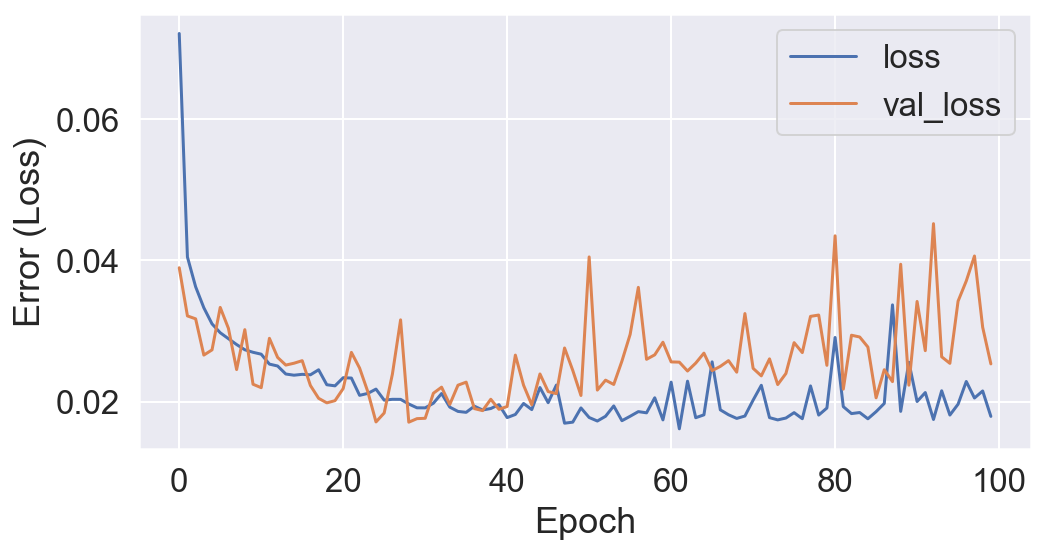

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error (Loss)')
plt.legend()
plt.grid(True)

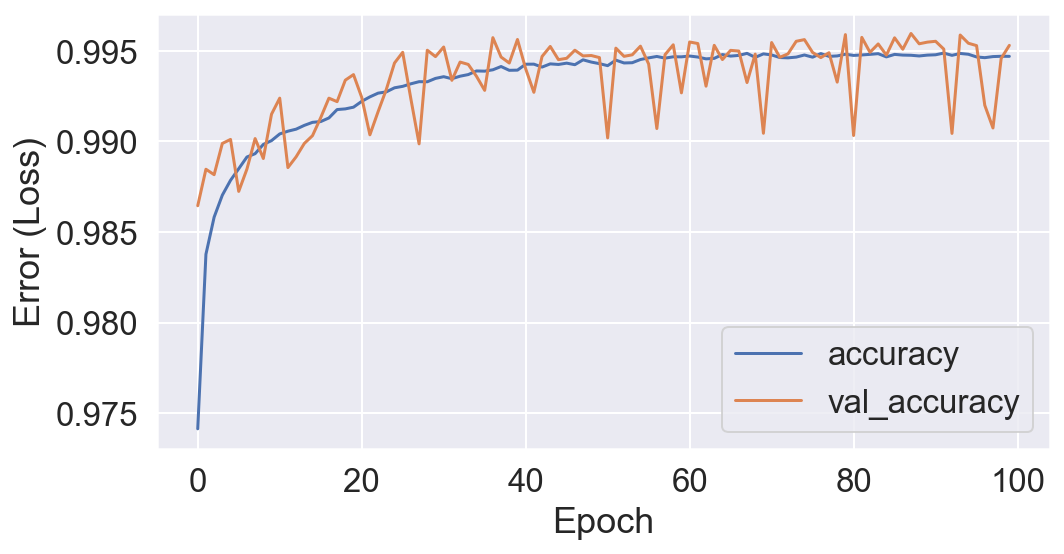

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Error (Loss)')
plt.legend()
plt.grid(True)

In [43]:
y_test_ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [55]:
# Test trained model.
y_pred = seq_model.predict(x_test_std)

8704/8704 [==============================] - 10s 1ms/step


In [59]:
for pred in y_pred:
    for i, num in enumerate(pred):
        if num != 1.0000000e+00:
            pred[i] = 0.
        else:
            pred[i] = 1.

y_pred

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [63]:
print(classification_report(y_test_ohe, y_pred, target_names=ohe.categories_[0]))

              precision    recall  f1-score   support

      benign       1.00      0.93      0.96    150796
         bot       1.00      0.68      0.81       584
 brute_force       1.00      0.66      0.80      2745
        ddos       1.00      0.98      0.99     38404
         dos       1.00      0.88      0.93     58124
    portscan       1.00      1.00      1.00     27208
  web_attack       1.00      0.04      0.08       643

   micro avg       1.00      0.93      0.96    278504
   macro avg       1.00      0.74      0.80    278504
weighted avg       1.00      0.93      0.96    278504
 samples avg       0.93      0.93      0.93    278504



c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
